# Pneumothorax Segmentation

## TODO: 
* Fix GPU Memory Isssues to run unet

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Introduction:

Pneumothorax can be caused by a blunt chest injury, damage from underlying lung disease, or most horrifying—it may occur for no obvious reason at all. On some occasions, a collapsed lung can be a life-threatening event.

Pneumothorax is usually diagnosed by a radiologist on a chest x-ray, and can sometimes be very difficult to confirm. An accurate AI algorithm to detect pneumothorax would be useful in a lot of clinical scenarios. AI could be used to triage chest radiographs for priority interpretation, or to provide a more confident diagnosis for non-radiologists.

In this notebook I create a model that could act as a solution in this scenario. Over the past few months I have learnt the majority of my deep learning knowledge through an amazing online course fast.ai. They provide an API that makes deep learning models fairly easy to implement. 

The focus of this notebook became the encoder design portion of the u-net. I pretrain the encoder to predict whether a lung contains the Pneumothorx disease or not before building up the unet from this archtitecture. In pretraining I utilize progressive re-sizing of the x-ray images to improve the model. Encoder archtitecture being implemented from the following paper: 
https://arxiv.org/abs/1812.01187

This data is provided by the SIIM-ACR Kaggle competition on Pneumothorax segemntation: 
https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation


## Data prep: 

In [1]:
from fastai.vision import *
import scipy.misc
import pydicom 
import cv2
import glob

In [97]:
def rle2mask(rle, width, height): # function to get the masks 
    if rle == ' -1':
        return np.zeros((width,height))
    else: 
        mask= np.zeros(width* height)
        array = np.asarray([int(x) for x in rle.split()])
        starts = array[0::2]
        lengths = array[1::2]
        current_position = 0
        for index, start in enumerate(starts):
            current_position += start
            mask[current_position:current_position+lengths[index]] = 255
            current_position += lengths[index]

        return mask.reshape(width, height)

In [ ]:
for id_ in range(0,len(labels)):
    arr = rle2mask(labels[" EncodedPixels"].iloc[id_], 1024, 1024)
    scipy.misc.imsave('masks/'+ labels.ImageId.iloc[id_] + '.jpg', arr.T)

In [ ]:
train_list = [os.path.basename(x) for x in glob.glob('train/' + './*.dcm')]

In [ ]:
for f in train_list:   
    ds = pydicom.read_file('train/' + f) # read dicom image
    img = ds.pixel_array # get image array
    image = cv2.resize(img,(512, 512))
    cv2.imwrite('train_jpg/' + f.replace('.dcm','.jpg'),image) # write png image

In [2]:
labels = pd.read_csv("train-rle.csv")

In [3]:
labels.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


In [4]:
labels['target'] = 0 # for pretraining the encoder. 1 diseased 0 not diseased 
idx = labels[labels[' EncodedPixels'] != ' -1'].index
labels.loc[idx, 'target'] = 1
labels.head()

,ImageId,EncodedPixels,target
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1,0
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1,0
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...,1
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...,1
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...,1


## Define Encoder Architecture:

In [5]:
import torch.nn as nn
import torch,math,sys
import torch.utils.model_zoo as model_zoo
from functools import partial

In [6]:
# Check that we are on the gpu:
def check_gpu():
    print(torch.cuda.current_device())
    print(torch.cuda.device(0))
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))
    
check_gpu()
torch.cuda.empty_cache()

0
1
Tesla P4


## Define some model components

In [ ]:
# Some helper functions: 
relu = nn.ReLU(inplace=True)

def initialize(init_weights): # initialize with kaiming init 
    if getattr(init_weights, 'bias', None) is not None: 
        nn.init.constant_(init_weights.bias, 0)
    if isinstance(init_weights, (nn.Conv2d,nn.Linear)): 
        nn.init.kaiming_normal_(init_weights.weight)
    for l in init_weights.children(): # recursive init weight matricies 
        initialize(l)

def conv(n_in, n_out, ks=3, stride=1, bias=False): # define a default conv 
    # only do 3x3 convs as per the paper suggestions 
    return nn.Conv2d(n_in, n_out, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

def identity(x): # function to return 
    return x
 
def conv_layer(n_in, n_out, ks=3, stride=1, zero_bnorm=False, activate=True): 
    #define a default conv layer
    bnorm = nn.BatchNorm2d(n_out) # define batch norm layer 
    # From the bag of tricks paper. ResNet-D trick. 
    nn.init.constant_(bnorm.weight, 0. if zero_bnorm else 1.)
    # a pretty standard cnn layer, conv -> batch norm -> relu 
    layers = [conv(n_in, n_out, ks, stride=stride), bnorm]
    if activate: 
        layers.append(relu)
    return nn.Sequential(*layers) # empty list contents in sequential model 

def EncoderModel(expansion, n_layers, name, **kwargs):
    model = Encoder(expansion, n_layers, **kwargs)
    return model

In [7]:
class Flatten(Module):
    def forward(self, x): 
        return x.view(x.size(0), -1) # to flatten out the final 3D feature map 
    
class ResBlock(Module):
    # Define ResBlock to use 
    def __init__(self, expansion, n_in, n_inter, stride=1):
        n_out, n_in = n_inter*expansion, n_in*expansion
        # according to the paper, turning zero batch norm on for some layers allows 
        # us to train at a higher learning rate. 
        layers  = [conv_layer(n_in, n_inter, 3, stride=stride),
                   conv_layer(n_inter, n_out, 3, zero_bnorm=True, activate=False)
        ] if expansion == 1 else [
                   conv_layer(n_in, n_inter, 1),
                   conv_layer(n_inter, n_inter, 3, stride=stride),
                   conv_layer(n_inter, n_out, 1, zero_bnorm=True, activate=False)
        ]
        
        self.convs = nn.Sequential(*layers)
        self.identity_conv = identity if n_in==n_out else conv_layer(n_in, n_out, 1, activate=False)
        self.pool = identity if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): 
        # given the smaller size of the training set can this be replaced by a dense block?
        # i.e. concat the outputs instead of addition (+) 
        return relu(self.convs(x) + self.identity_conv(self.pool(x))) # define forward pass  
    
class Encoder(nn.Sequential):
    def __init__(self, expansion, layers, c_in=1, c_out=1000):
        stem = []
        sizes = [c_in,32,32,64] # bag of tricks paper recommends 3 3x3 convs in a row
        for i in range(3): # this is refered to as the stem and comes before the blocks
            # it becomes the very start of the cnn
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))

        block_szs = [64//expansion,64,128,256,512]
        # Create res-blocks here 
        # stride 2 after the first layer. Want to take advantage of input data and computation. 
        # important because when doing segmentation we want as much info from the input pixels
        # as possible 
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(block_szs[-1]*expansion, c_out),
        )
        
        initialize(self)

    def _make_layer(self, expansion, n_in, n_out, blocks, stride):
        return nn.Sequential(*[ResBlock(expansion, n_in if i==0 else n_out, 
                                        n_out, stride if i==0 else 1) for i in range(blocks)])


In [8]:
# create model 
me = sys.modules[__name__]
name = f'Encoder{50}'
setattr(me, name, partial(EncoderModel, expansion=4, n_layers=[3,4,6,3], name=name))

## Training the Encoder: 

In [9]:
from fastai import *

In [10]:
optimizer = optim.Adam

In [11]:
def get_labels(x): 
    x =str(x)
    end = x.split(os.sep)[-1]
    image_id = os.path.splitext(end)[0]
    return labels[labels.ImageId == image_id].target.iloc[0]

In [12]:
labels.target.value_counts() # not too unbalanced 

0    8296
1    3286
Name: target, dtype: int64

### Data Bunch:

In [13]:
data =  (ImageList.from_folder(path=Path('train_jpg/', df = labels))
        .split_by_rand_pct(0.2)
        .label_from_func(get_labels)
        .transform(size=128)       
        .databunch(path=Path('.'), bs=32)
        .normalize())

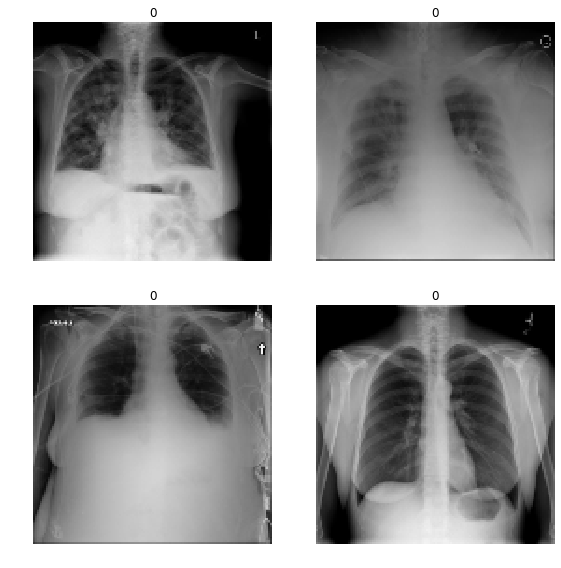

In [14]:
data.show_batch(2) # create a 2 x 2 grid 

In [15]:
from fastai.callbacks import SaveModelCallback
encoder = Learner(data, 
                  Encoder50(), 
                  metrics = accuracy, 
                  opt_func = optim.Adam)

In [45]:
encoder.summary()

Encoder
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 64, 64]         864        True      
______________________________________________________________________
BatchNorm2d          [32, 64, 64]         64         True      
______________________________________________________________________
ReLU                 [2048, 4, 4]         0          False     
______________________________________________________________________
Conv2d               [32, 64, 64]         9,216      True      
______________________________________________________________________
BatchNorm2d          [32, 64, 64]         64         True      
______________________________________________________________________
ReLU                 [2048, 4, 4]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         18,432     True      
______________________________________________________

In [46]:
torch.cuda.empty_cache()

In [47]:
encoder.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


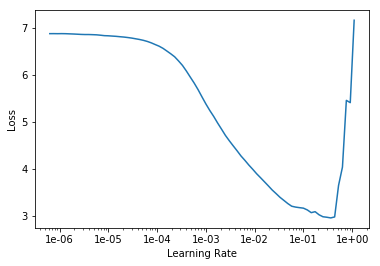

In [48]:
encoder.recorder.plot()

In [49]:
encoder.fit_one_cycle(20, 3e-3, callbacks = [SaveModelCallback(encoder, every='improvement', 
                                                               monitor='valid_loss', 
                                                               name ='best')])

epoch,train_loss,valid_loss,accuracy,time
0,0.524673,0.494702,0.783607,00:52
1,0.516059,0.483098,0.777049,00:53
2,0.536748,0.508218,0.785948,00:53
3,0.492079,0.560873,0.783607,00:54
4,0.494894,0.644256,0.700703,00:54
5,0.469533,0.484544,0.770960,00:54
6,0.452815,0.554655,0.790632,00:54
7,0.406537,0.470442,0.767681,00:54
8,0.407063,0.663663,0.641218,00:53
9,0.376272,0.452977,0.823888,00:54


Better model found at epoch 0 with valid_loss value: 0.49470168352127075.
Better model found at epoch 1 with valid_loss value: 0.48309803009033203.
Better model found at epoch 7 with valid_loss value: 0.47044169902801514.
Better model found at epoch 9 with valid_loss value: 0.45297732949256897.
Better model found at epoch 12 with valid_loss value: 0.40065279603004456.
Better model found at epoch 13 with valid_loss value: 0.3944651782512665.


Not bad given this model was built from scratch!

## Resizing: 

In [50]:
# train the network on the larger images 
data =  (ImageList.from_folder(path=Path('train_jpg/', df = labels))
        .split_by_rand_pct(0.2)
        .label_from_func(get_labels)
        .transform(size=256)       
        .databunch(path=Path('.'), bs=32)
        .normalize())

In [51]:
encoder.data = data # replace the data bunch 

In [52]:
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


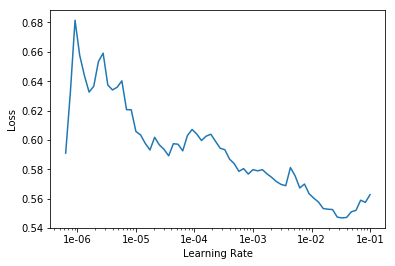

In [53]:
encoder.lr_find() # find a good lr 
encoder.recorder.plot()

In [54]:
# fit again on the one-cycle scheduler 
encoder.fit_one_cycle(10, 1e-2, callbacks = [SaveModelCallback(encoder, every='improvement', 
                                                               monitor='valid_loss', 
                                                               name ='best-256')])

epoch,train_loss,valid_loss,accuracy,time
0,0.424152,0.434886,0.799532,02:31
1,0.440369,0.435819,0.807494,02:31
2,0.443455,0.490367,0.775176,02:30
3,0.420458,0.416704,0.829977,02:30
4,0.411817,0.404566,0.829977,02:30
5,0.380310,0.397459,0.818735,02:31
6,0.366005,0.361928,0.843091,02:30
7,0.345459,0.354782,0.840749,02:30
8,0.285742,0.354978,0.842623,02:30
9,0.245348,0.366559,0.845433,02:30


Better model found at epoch 0 with valid_loss value: 0.4348856508731842.
Better model found at epoch 3 with valid_loss value: 0.41670405864715576.
Better model found at epoch 4 with valid_loss value: 0.40456622838974.
Better model found at epoch 5 with valid_loss value: 0.39745914936065674.
Better model found at epoch 6 with valid_loss value: 0.36192771792411804.
Better model found at epoch 7 with valid_loss value: 0.3547821044921875.


Given the success of this training cycle we can train some more at a lower learning rate before re-sizing again. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


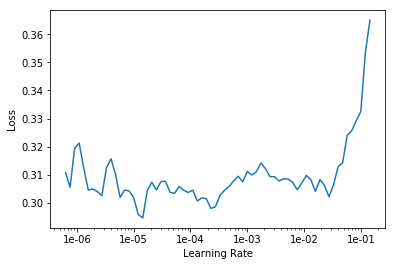

In [55]:
encoder.lr_find()
encoder.recorder.plot()

In [56]:
encoder.fit_one_cycle(5, 3e-3, callbacks = [SaveModelCallback(encoder, every='improvement', 
                                                               monitor='valid_loss', 
                                                               name ='best-256')])

epoch,train_loss,valid_loss,accuracy,time
0,0.298945,0.385765,0.840749,02:30
1,0.320271,0.460050,0.799063,02:30
2,0.297051,0.373292,0.842155,02:30
3,0.219415,0.379158,0.846838,02:30
4,0.138188,0.417947,0.851991,02:30


Better model found at epoch 0 with valid_loss value: 0.38576528429985046.
Better model found at epoch 2 with valid_loss value: 0.3732917010784149.


Finally train on the full sized images...

In [57]:
data =  (ImageList.from_folder(path=Path('train_jpg/', df = labels))
        .split_by_rand_pct(0.2)
        .label_from_func(get_labels) # no transform here 
        .databunch(path=Path('.'), bs=32)
        .normalize())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


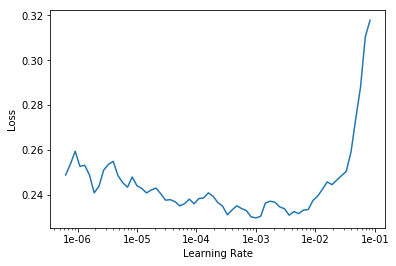

In [58]:
encoder.lr_find()
encoder.recorder.plot()

In [59]:
encoder.fit_one_cycle(8, 3e-3, callbacks = [SaveModelCallback(encoder, every='improvement', 
                                                               monitor='valid_loss', 
                                                               name ='best-512')])

epoch,train_loss,valid_loss,accuracy,time
0,0.214468,0.404874,0.836066,02:30
1,0.271611,0.427333,0.805621,02:30
2,0.260415,0.406880,0.827166,02:30
3,0.233230,0.524140,0.832787,02:30
4,0.187599,0.479718,0.818267,02:30
5,0.079097,0.623722,0.826230,02:30
6,0.030254,0.696199,0.830445,02:30
7,0.014238,0.708058,0.829040,02:30


Better model found at epoch 0 with valid_loss value: 0.4048740267753601.


Good starting point for segmentation

In [16]:
encoder.load("encoder_model_best")

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ResBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (8540 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,1,1
Path: train_jpg_512;

Valid: LabelList (2135 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,1,0
Path: train_jpg_512;

Test: None, model=Encoder(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Bat

## U-Net

In [18]:
path_img = Path('train_jpg_512/')

class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

## Some Image re-sizing 

In [ ]:
from PIL import Image
import glob 

train_list = [os.path.basename(x) for x in glob.glob('train_jpg/' + './*.jpg')]

for f in train_list:   
    ds =  Image.open('train_jpg/' + f) # read dicom image
    image = ds.resize((512, 512), Image.NEAREST) 
    image.save('train_jpg_512/' + f.replace('.jpg','.jpg')) # write png image

In [143]:
mask_list = [os.path.basename(x) for x in glob.glob('masks/' + './*.jpg')]
for f in mask_list:   
    ds =  Image.open('masks/' + f) # read dicom image
    image = ds.resize((512, 512), Image.NEAREST) 
    image.save('masks/' + f.replace('.jpg','.jpg')) # write png image

## Create Data Bunch for u-net

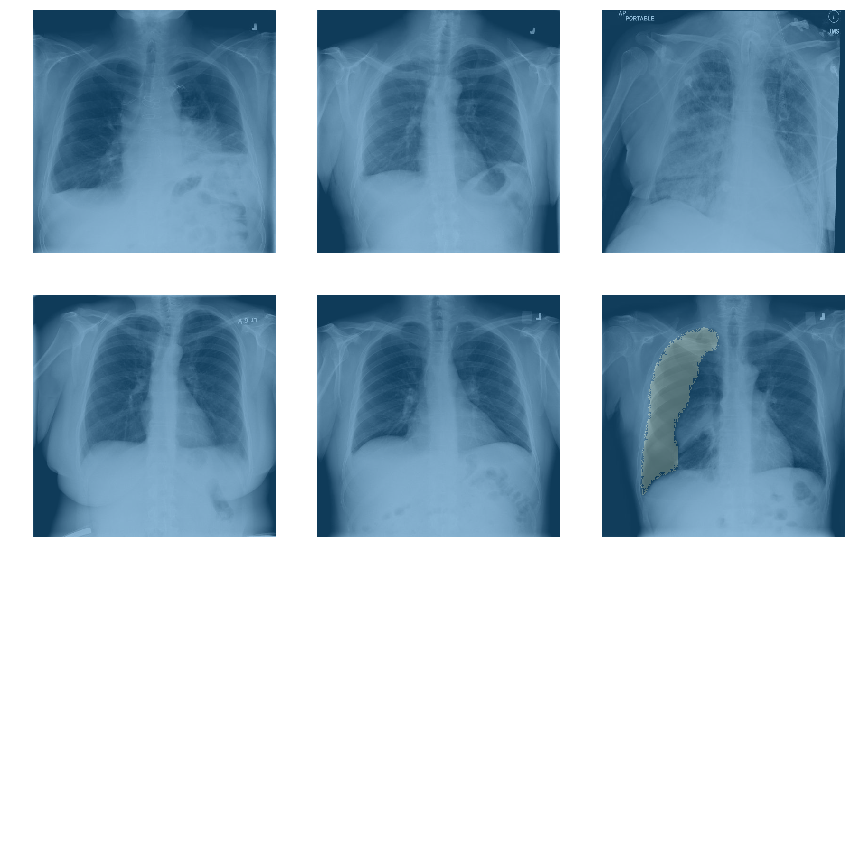

In [19]:
# Create databunch
data = (SegmentationItemList.from_folder(path=Path('train_jpg/'))
        .split_by_rand_pct(0.2)
        .label_from_func(lambda x : str(x).replace('train_jpg', 'masks'), classes=[0, 1])
        .transform(size=128, tfm_y =True) # also reseize the masks        
        .databunch(path=Path('.'), bs=32)
        .normalize())

data.show_batch(4) # create a 4 x 4 grid 
# Bottom right image shows the diseased area for a non-healthy lung

In [20]:
from fastai.vision.models.unet import DynamicUnet

In [21]:
pretrained_encoder = nn.Sequential(*list(encoder.model.children())[:-2]).cpu()

In [22]:
next(pretrained_encoder.parameters()).is_cuda

False

In [23]:
partial_unet = DynamicUnet(encoder = pretrained_encoder.cpu() , n_classes =2)

In [24]:
unet = Learner(data,
               model = partial_unet, 
               loss_func = dice, 
               metrics = accuracy, 
               opt_func = optim.Adam,
               wd = 0.01 )

In [ ]:
unet.fit_one_cycle(20, 3e-3, callbacks = [SaveModelCallback(unet, every='improvement', 
                                                               monitor='valid_loss', 
                                                               name ='best_unet-512')])

Some GPU memory errors occured at this point. Need to investiagte further. Training procedure would be similar to training the encoder. Progressive re-sizing training of the unet. 

# END

In [37]:
# Some gpu memory management 
import gc
gc.collect()

20

In [35]:
torch.cuda.empty_cache()

In [188]:
del partial_unet

In [199]:
del data

In [34]:
del encoder

In [33]:
encoder.destroy()

this Learner object self-destroyed - it still exists, but no longer usable
